In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from src.data_manage import get_all_labels
from src.cupido import get_scores_pred

/home/gambacorta/Scrivania/cardio_cupido/pyenv_cupido/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

In [3]:
labels_dataset = get_all_labels()

In [4]:
from matplotlib import colors as mcolors
from matplotlib import cm

# Scores di CV !

In [5]:
cav_scores = pd.DataFrame(index=labels_dataset['cav'].index)
for seed in range(10):
    for split in range(10):
        tmp_scores = get_scores_pred('cav', split, seed, cls_folder='cls=XGB')
        cav_scores = pd.concat([ cav_scores, tmp_scores ], axis=1, ignore_index=True)

In [6]:
nav_scores = pd.DataFrame(index=labels_dataset['nav'].index)
for seed in range(10):
    for split in range(10):
        tmp_scores = get_scores_pred('nav', split, seed)
        nav_scores = pd.concat([ nav_scores, tmp_scores ], axis=1, ignore_index=True)

In [7]:
erg_scores = pd.DataFrame(index=labels_dataset['erg'].index)
for seed in range(10):
    for split in range(10):
        tmp_scores = get_scores_pred('erg', split, seed)
        erg_scores = pd.concat([ erg_scores, tmp_scores ], axis=1, ignore_index=True)

In [8]:
def plot_scores_preds(scores, name_dataset):
    true_labels = labels_dataset[name_dataset]
    n_mols, n_repeat = scores.shape
    pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )
    mask_correct = np.expand_dims(true_labels,1) == pred_labels
    mask_positive = np.repeat(np.expand_dims(true_labels == 1,1), n_repeat, 1)
    mask_nan = scores.isna()

    fig, axes= plt.subplots(ncols=2, nrows=1, figsize=(9,5), sharey=True)

    axes[0].hist(scores.values.flatten()[ mask_correct.values.flatten() & ~mask_positive.flatten() & ~mask_nan.values.flatten() ],
            range=(0, .5), bins=5, ec='black', label='No-Blocker')
    axes[0].hist(scores.values.flatten()[ mask_correct.values.flatten() & mask_positive.flatten() & ~mask_nan.values.flatten() ],
            range=(.5, 1), bins=5, ec='black',label='Blocker')

    axes[0].set_title(f'Correct predicted {name_dataset.upper()} molecules')
    axes[0].set_xlabel('Score')
    axes[0].set_ylabel('Counts')
    axes[0].set_xlim(0,1)
    axes[0].legend()

    axes[1].hist(scores.values.flatten()[ ~mask_correct.values.flatten() & ~mask_positive.flatten() & ~mask_nan.values.flatten() ],
            range=(.5,1), bins=5, ec='black', label='No-Blocker')
    axes[1].hist(scores.values.flatten()[ ~mask_correct.values.flatten() & mask_positive.flatten() & ~mask_nan.values.flatten() ],
            range=(0, .5), bins=5, ec='black',label='Blocker')

    axes[1].set_title(f'Uncorrect predicted {name_dataset.upper()} molecules')
    axes[1].set_xlabel('Score')

    axes[1].legend()

    axes[1].set_xlim(0,1)

    plt.close(fig)

    return fig

In [9]:
PlotPredCAV=plot_scores_preds(cav_scores, 'cav')

/tmp/ipykernel_3067466/306861376.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )


In [10]:
PlotPredCAV.savefig('Figures/CorrectPred_CAV.png')

In [ ]:
PlotPredNAV=plot_scores_preds(nav_scores, 'nav')

/tmp/ipykernel_3067466/306861376.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )


In [12]:
PlotPredNAV.savefig('Figures/CorrectPred_NAV.png')

In [ ]:
PlotPredERG=plot_scores_preds(erg_scores, 'erg')

/tmp/ipykernel_3067466/306861376.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )


In [14]:
PlotPredERG.savefig('Figures/CorrectPred_ERG.png')

In [15]:
from src.target_configs import TARGET_NAMES as titles, DATASET as dataset

In [16]:
def plot_ad(scores, name_dataset, ax=None):

    true_labels = labels_dataset[name_dataset]
    n_mols, n_repeat = scores.shape
    pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )
    mask_correct = np.expand_dims(true_labels,1) == pred_labels
    # mask_positive = np.repeat(np.expand_dims(true_labels == 1,1), n_repeat, 1)
    mask_nan = scores.isna()
    
    scores_correct = scores.values.flatten()[ mask_correct.values.flatten() & ~mask_nan.values.flatten() ]
    scores_uncorrect = scores.values.flatten()[ ~mask_correct.values.flatten() & ~mask_nan.values.flatten() ]

    bins_value, bin_edges = np.histogram(scores_correct,
                                        bins=11, range=(0,1))
    bins_value_inc, _ = np.histogram(scores_uncorrect,
                                    bins=11, range=(0,1))

    ratio = bins_value/(bins_value+bins_value_inc)

    # Plot the ratio
    norm = mcolors.Normalize(vmin=ratio.min(), vmax=ratio.max())
    #cmap = cm.PiYG
    cmap=cm.Blues
    #('Sequential', 'Blues')
    # You can choose any other colormap from Matplotlib
    width=bin_edges[1]- bin_edges[0]

    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))

    ax.bar(bin_edges[:-1], ratio, width=width, edgecolor='black',color=cmap(norm(ratio)),align='edge')
    ax.set_xlabel('Probability Bins')
    ax.set_ylabel('Ratio of Correct to Total')
    ax.set_ylim(0.5,1)
    ax.set_xlim(0,1)
    ax.set_title(titles[name_dataset])
    ax.set_xticks([ t/10 for t in range(11)])
    #Ratio of Correct Predictions to Total Predictions in Each Probability Bin

    if fig is not None:
        plt.close(fig)
        return fig

In [32]:
ad_cav=plot_ad(cav_scores, 'cav')

/tmp/ipykernel_2882002/4065309330.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )


In [27]:
ad_cav.savefig('Figures/AD_cav.png')

In [19]:
ad_nav=plot_ad(nav_scores, 'nav')

/tmp/ipykernel_2882002/260591303.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )


In [20]:
ad_nav.savefig('Figures/AD_nav.png')

In [21]:
ad_erg=plot_ad(erg_scores, 'erg')

/tmp/ipykernel_2882002/260591303.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )


In [22]:
ad_erg.savefig('Figures/AD_erg.png')

In [17]:
titles

{'nav': 'Naᵥ1.5', 'cav': 'Caᵥ1.2', 'erg': 'ERG'}

/tmp/ipykernel_3067466/4065309330.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pred_labels = scores.applymap(lambda x: np.nan if pd.isna(x) else (0 if x < .5 else 1) )


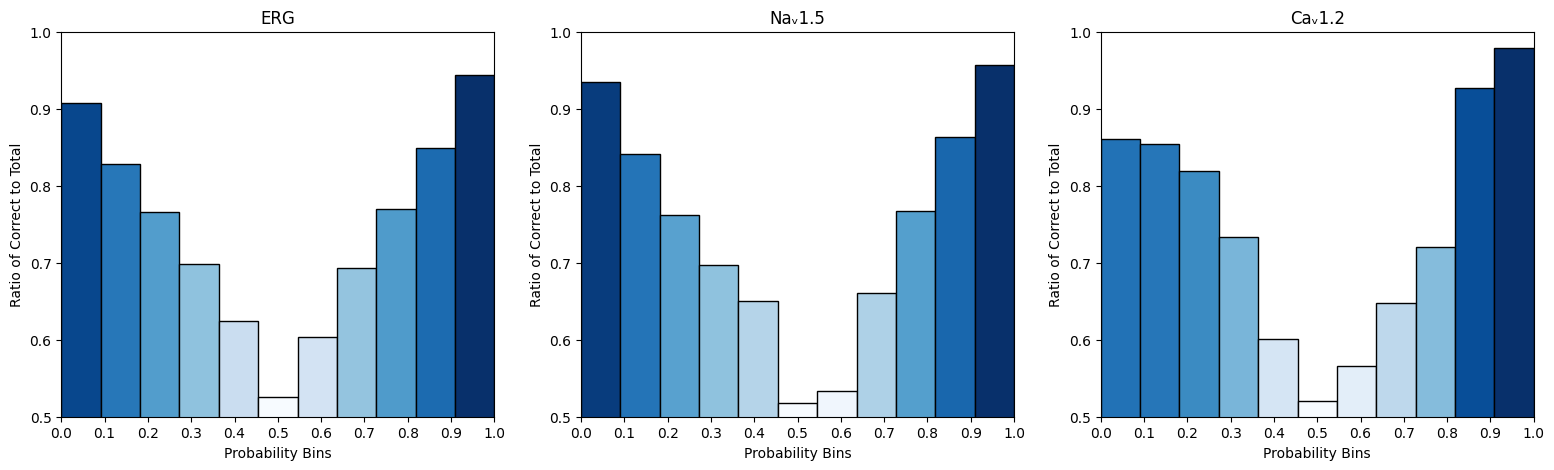

In [28]:
fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(19,5), gridspec_kw={'wspace':0.2})

for ax, target, scores in zip(axes.flatten(), dataset,[erg_scores, nav_scores, cav_scores]):
    plot_ad(scores, target, ax)

In [29]:
fig.savefig('Figures/AD_full.png',bbox_inches='tight')

# Distribution Dataset

In [13]:
from src.target_configs import TARGET_NAMES

In [14]:
import seaborn as sns

In [15]:
pIC50s={k : pd.read_csv(f'dataset/{k}.csv', usecols=['avg2']).squeeze() for k in ['erg','nav','cav']}

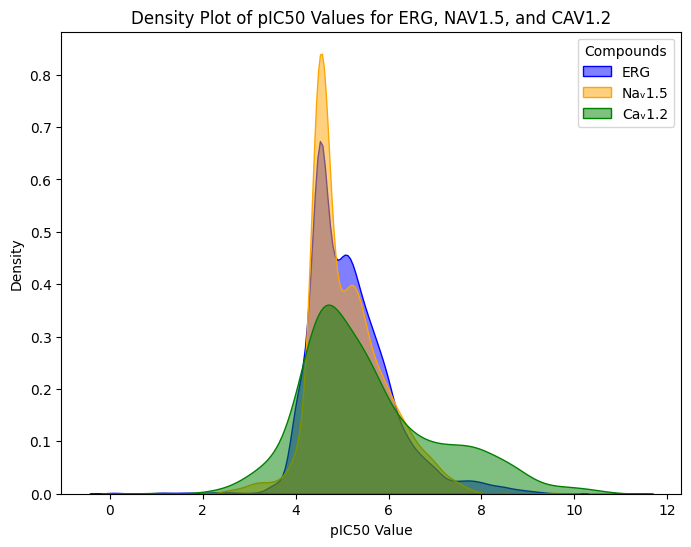

In [16]:
colors=['blue','orange','green']
plt.figure(figsize=(8,6))
for (dataset, pIC50), color in zip(pIC50s.items(), colors):
    sns.kdeplot(pIC50, fill=True, alpha=0.5, label=TARGET_NAMES[dataset], color=color)

# Imposta etichette e titolo
plt.xlabel('pIC50 Value')
plt.ylabel('Density')
plt.title('Density Plot of pIC50 Values for ERG, NAV1.5, and CAV1.2')
plt.legend(title='Compounds')  # Legenda per distinguere le distribuzioni

# Mostra il grafico
plt.show()

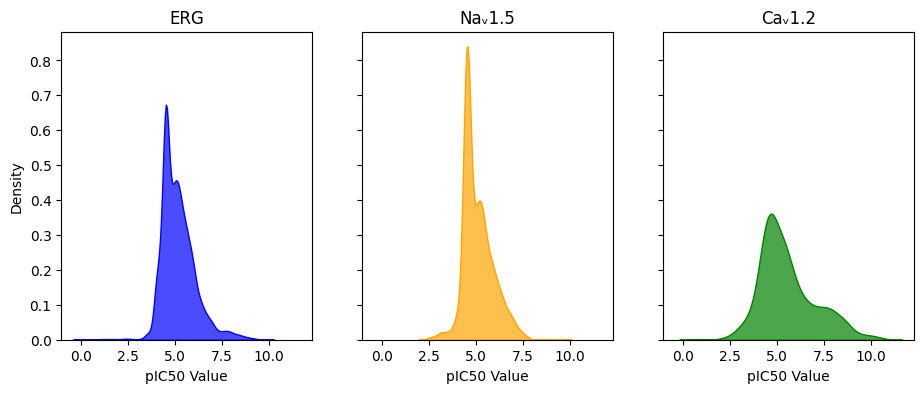

In [17]:
colors=['blue','orange','green']
fig,axes=plt.subplots( nrows=1 , ncols=3, sharey=True, figsize=(11,4), sharex=True)
for (dataset, pIC50), ax, color in zip(pIC50s.items(), axes.flatten(), colors):
    sns.kdeplot(pIC50, fill=True, alpha=0.7, ax=ax, color=color)
    #ax.grid(True, which='both', alpha=0.3)
    #ax.set_facecolor('whitesmoke')

    ax.set_xlabel('pIC50 Value')
    ax.set_ylabel('Density')
    
    ax.set_title(TARGET_NAMES[dataset])
    fig.supxlabel("Tanimoto Similarity")
    #ax.set_xticks(np.arange(0, 11))

    #ax.set_xticks(fontsize=12)
    #ax.set_yticks(fontsize=12)